## Code to train DQN with APSF representations

In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)

2020-10-31 10:50:08,894 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-10-31 10:50:13,322 - root - INFO: steps 5000, episodic_return_test -180.10(18.88)
2020-10-31 10:50:16,534 - root - INFO: steps 10000, episodic_return_test -160.10(25.24)
2020-10-31 10:50:19,752 - root - INFO: steps 15000, episodic_return_test -180.20(18.78)
2020-10-31 10:50:22,898 - root - INFO: steps 20000, episodic_return_test -121.90(30.26)
2020-10-31 10:50:26,098 - root - INFO: steps 25000, episodic_return_test -141.40(28.31)
2020-10-31 10:50:29,254 - root - INFO: steps 30000, episodic_return_test -121.20(30.52)
2020-10-31 10:50:32,352 - root - INFO: steps 35000, episodic_return_test -102.40(30.87)
2020-10-31 10:50:35,416 - root - INFO: steps 40000, episodic_return_test -43.60(24.74)
2020-10-31 10:50:38,414 - root - INFO: steps 45000, episodic_return_test -8.40(1.51)
2020-10-31 10:50:41,455 - root - INFO: steps 50000, episodic_return_test -27.50(18.23)
2020-10-31 10:50:44,437 - root - INFO: step

In [4]:
# plt.figure(figsize=(18,6))
# plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
# plt.xlabel('timesteps'), plt.ylabel('returns')
# plt.title('DQN performance on ' + game), plt.show()

### Learning the state representations using APSF

In [5]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()

In [6]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)

2020-10-31 10:51:15,003 - root - INFO: steps 0, 322638769.23 steps/s
2020-10-31 10:51:16,080 - root - INFO: steps 1000, 930.38 steps/s
2020-10-31 10:51:17,105 - root - INFO: steps 2000, 977.74 steps/s
2020-10-31 10:51:18,112 - root - INFO: steps 3000, 993.75 steps/s
2020-10-31 10:51:19,143 - root - INFO: steps 4000, 971.92 steps/s
2020-10-31 10:51:20,245 - root - INFO: steps 5000, 908.28 steps/s
2020-10-31 10:51:21,334 - root - INFO: steps 6000, 920.12 steps/s
2020-10-31 10:51:22,418 - root - INFO: steps 7000, 923.32 steps/s
2020-10-31 10:51:23,515 - root - INFO: steps 8000, 913.18 steps/s
2020-10-31 10:51:24,626 - root - INFO: steps 9000, 901.45 steps/s
2020-10-31 10:51:25,749 - root - INFO: steps 10000, 891.92 steps/s
2020-10-31 10:51:26,835 - root - INFO: steps 11000, 922.37 steps/s
2020-10-31 10:51:27,942 - root - INFO: steps 12000, 904.27 steps/s
2020-10-31 10:51:29,079 - root - INFO: steps 13000, 880.97 steps/s
2020-10-31 10:51:30,218 - root - INFO: steps 14000, 878.74 steps/s
20

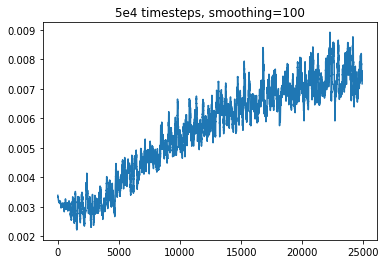

(Text(0.5, 1.0, '5e4 timesteps, smoothing=100'), None)

In [7]:
loss_lr_em3 = avdsr.loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec, kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()
# plt.subplot(122), plt.plot(avdsr.retu)

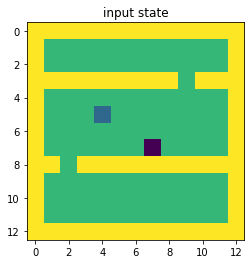

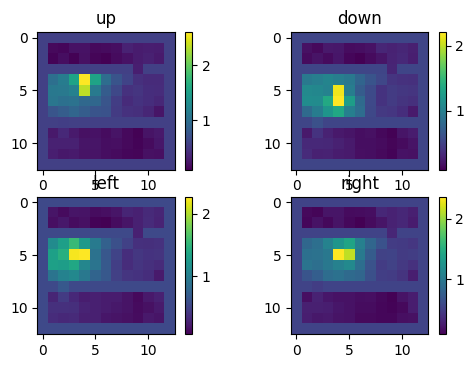

In [8]:
from deep_rl.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix()
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
# env.current_cell = (5,5)
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [9]:
params_count(avdsr.network.psi2q)

169

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [10]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [11]:
def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [15]:
r_c0 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=0)
r_c1 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=1)
r_dqn_base_16 = runNAgents(dqn_feature, runs=2)

runs:   0%|          | 0/2 [00:00<?, ?it/s]

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-10-31 10:55:20,144 - root - INFO: steps 0, episodic_return_test -180.30(18.69)
2020-10-31 10:55:26,958 - root - INFO: steps 5000, episodic_return_test -160.20(25.17)
2020-10-31 10:55:33,883 - root - INFO: steps 10000, episodic_return_test -140.40(28.79)
2020-10-31 10:55:40,495 - root - INFO: steps 15000, episodic_return_test -63.90(28.18)
2020-10-31 10:55:47,230 - root - INFO: steps 20000, episodic_return_test -103.00(30.69)
2020-10-31 10:55:53,833 - root - INFO: steps 25000, episodic_return_test -6.60(1.09)
2020-10-31 10:56:00,344 - root - INFO: steps 30000, episodic_return_test -8.40(1.48)
2020-10-31 10:56:06,813 - root - INFO: steps 35000, episodic_return_test -6.20(1.55)
2020-10-31 10:56:13,340 - root - INFO: steps 40000, episodic_return_test -7.70(1.34)
2020-10-31 10:56:20,158 - root - INFO: steps 45000, episodic_return_test -9.70(1.68)
2020-10-31 10:56:27,074 - root - INFO: steps 50000, episodic_return_test -6.80(0.81)
runs:  50%|█████     | 1/2 [01:07<01:07, 67.55s/it]

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-10-31 10:56:27,713 - root - INFO: steps 0, episodic_return_test -180.30(18.69)
2020-10-31 10:56:34,561 - root - INFO: steps 5000, episodic_return_test -82.50(30.34)
2020-10-31 10:56:41,114 - root - INFO: steps 10000, episodic_return_test -43.40(24.77)
2020-10-31 10:56:47,903 - root - INFO: steps 15000, episodic_return_test -63.90(28.18)
2020-10-31 10:56:54,632 - root - INFO: steps 20000, episodic_return_test -44.60(24.59)
2020-10-31 10:57:01,272 - root - INFO: steps 25000, episodic_return_test -4.90(0.73)
2020-10-31 10:57:07,767 - root - INFO: steps 30000, episodic_return_test -5.30(1.00)
2020-10-31 10:57:14,378 - root - INFO: steps 35000, episodic_return_test -6.40(1.39)
2020-10-31 10:57:20,994 - root - INFO: steps 40000, episodic_return_test -8.50(1.61)
2020-10-31 10:57:27,748 - root - INFO: steps 45000, episodic_return_test -9.70(1.16)
2020-10-31 10:57:34,703 - root - INFO: steps 50000, episodic_return_test -6.50(1.15)
runs:   0%|          | 0/2 [00:00<?, ?it/s]

IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=['psi2q.w'])


2020-10-31 10:57:35,455 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-10-31 10:57:42,732 - root - INFO: steps 5000, episodic_return_test -160.50(24.98)
2020-10-31 10:57:49,816 - root - INFO: steps 10000, episodic_return_test -82.20(30.42)
2020-10-31 10:57:56,702 - root - INFO: steps 15000, episodic_return_test -26.70(18.31)
2020-10-31 10:58:03,572 - root - INFO: steps 20000, episodic_return_test -24.60(18.50)
2020-10-31 10:58:10,434 - root - INFO: steps 25000, episodic_return_test -10.50(1.13)
2020-10-31 10:58:17,368 - root - INFO: steps 30000, episodic_return_test -7.80(1.78)
2020-10-31 10:58:24,192 - root - INFO: steps 35000, episodic_return_test -7.10(1.24)
2020-10-31 10:58:31,073 - root - INFO: steps 40000, episodic_return_test -10.40(1.58)
2020-10-31 10:58:38,060 - root - INFO: steps 45000, episodic_return_test -8.80(1.29)
2020-10-31 10:58:45,043 - root - INFO: steps 50000, episodic_return_test -63.20(28.33)
runs:  50%|█████     | 1/2 [01:10<01:10, 70.34s/it]

IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=['psi2q.w'])


2020-10-31 10:58:45,829 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-10-31 10:58:53,176 - root - INFO: steps 5000, episodic_return_test -180.10(18.88)
2020-10-31 10:59:00,380 - root - INFO: steps 10000, episodic_return_test -122.00(30.21)
2020-10-31 10:59:07,452 - root - INFO: steps 15000, episodic_return_test -84.10(29.94)
2020-10-31 10:59:14,282 - root - INFO: steps 20000, episodic_return_test -10.40(1.42)
2020-10-31 10:59:21,168 - root - INFO: steps 25000, episodic_return_test -24.80(18.48)
2020-10-31 10:59:28,353 - root - INFO: steps 30000, episodic_return_test -121.40(30.45)
2020-10-31 10:59:35,484 - root - INFO: steps 35000, episodic_return_test -84.50(29.83)
2020-10-31 10:59:42,526 - root - INFO: steps 40000, episodic_return_test -27.20(18.27)
2020-10-31 10:59:49,388 - root - INFO: steps 45000, episodic_return_test -6.90(1.42)
2020-10-31 10:59:56,240 - root - INFO: steps 50000, episodic_return_test -7.70(1.57)
runs: 100%|██████████| 2/2 [02:21<00:00, 70.60s/it

In [16]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

In [ ]:
rewards_dict = {'DQN (h=(16,))': r_dqn_base_16[1:],
                'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c0[1:],
                'APSF($\pi_{\epsilon=1}$) - 2708 parameters': r_c1[1:],
               }

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on 3rooms(h) env')